# Pneumonia Classification
url to data: https://www.kaggle.com/datasets/ahmedhaytham/chest-xray-images-pneumonia-with-new-class

## Import modules

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization
from tensorflow.keras import Model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import os

## Data preprocessing
### Extracting data

In [821]:
zipfile.ZipFile('archive.zip').extractall()

In [2]:
PATHS = {
    'train': 'Data_blance/Train/',
    'val': 'Data_blance/Val/',
    'test': 'Data_blance/Test/',
}

os.mkdir('checkpoints')

## Loading data
Loading data into 3 datasets and setting image size to 200 x 200

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(PATHS['train'], image_size=(200, 200))
val_dataset = tf.keras.utils.image_dataset_from_directory(PATHS['val'], image_size=(200, 200))
test_dataset = tf.keras.utils.image_dataset_from_directory(PATHS['test'], image_size=(200, 200))

Found 3900 files belonging to 3 classes.
Found 279 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


Showing class names

In [4]:
class_names = train_dataset.class_names
class_names

['Normal', 'bacteria', 'virus']

## Showing data

In [5]:
plt.figure(figsize=(10, 10))
images, labels = next(iter(train_dataset))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(class_names[labels[i]] + ' ' + str(labels[i].numpy()))
  plt.axis("off")

shape = images.shape[1:]

2022-11-16 23:42:01.543880: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


As you can see it is hard to point differences between healthy and ill lungs. That's why it is a good idea to use AI to solve this problem.

## Normalizing data and setting labels

In [6]:
def to_one_hot(image, label):
    return (image, tf.one_hot(label, depth=3))

def normalize(image, label):
    return (image*1./255, label)

train = train_dataset.map(to_one_hot)
train = train.map(normalize)
train = train.shuffle(500)

val = val_dataset.map(to_one_hot)
val = val.map(normalize)
val = val.shuffle(500)

test = test_dataset.map(to_one_hot)
test = test.map(normalize)
test = test.shuffle(500)

## Building a model

In [7]:
def build_model():
    input_layer = Input(shape=shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(3, activation='softmax')(x)

    return Model(inputs=input_layer, outputs=x)

In [8]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496 

### Creating checkponts and compiling the model

In [9]:
filepath_loss = os.path.join('checkpoints', 'weights.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5')
filepath_acc = os.path.join('checkpoints', 'weights.epoch{epoch:02d}-acc{val_accuracy:.2f}.hdf5')


checkpoint_loss = ModelCheckpoint(filepath=filepath_loss,  monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_acc = ModelCheckpoint(filepath=filepath_acc,  monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training

In [10]:
hist = model.fit(train, epochs=35, validation_data=val, callbacks=[checkpoint_loss, checkpoint_acc])

Epoch 1/35
122/122 [==============================] - ETA: 0s - loss: 1.5961 - accuracy: 0.6705
Epoch 1: val_loss improved from inf to 23.75552, saving model to checkpoints/weights.epoch01-loss23.76.hdf5

Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to checkpoints/weights.epoch01-acc0.33.hdf5
122/122 [==============================] - 66s 492ms/step - loss: 1.5961 - accuracy: 0.6705 - val_loss: 23.7555 - val_accuracy: 0.3333
Epoch 2/35
122/122 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7513
Epoch 2: val_loss improved from 23.75552 to 10.71723, saving model to checkpoints/weights.epoch02-loss10.72.hdf5

Epoch 2: val_accuracy did not improve from 0.33333
122/122 [==============================] - 69s 521ms/step - loss: 0.5613 - accuracy: 0.7513 - val_loss: 10.7172 - val_accuracy: 0.3333
Epoch 3/35
122/122 [==============================] - ETA: 0s - loss: 0.5126 - accuracy: 0.7728
Epoch 3: val_loss improved from 10.71723 to 2.64422, savin

### Plotting history

In [11]:
plt.plot(hist.history['loss'], color='orange', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

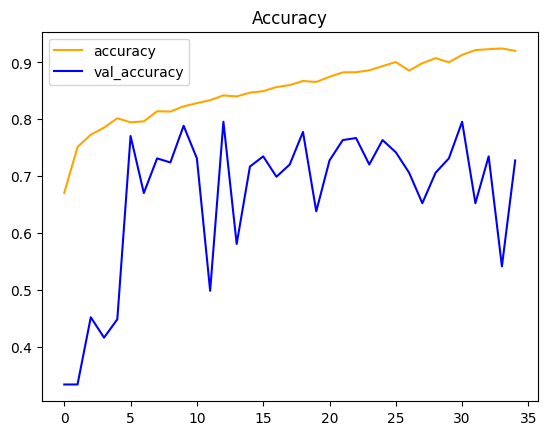

In [12]:
plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='blue', label='val_accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

## Loading the best weights

State after 35 epochs:

In [13]:
loss, accuracy = model.evaluate(test)
print(f"Loss: {loss:.2f}, Accuracy: {accuracy:.2f}")


10/10 [==============================] - 2s 120ms/step - loss: 1.2845 - accuracy: 0.6967
Loss: 1.28, Accuracy: 0.70


Loaded weights:

In [17]:
new_model = build_model()
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

new_model.load_weights('checkpoints/weights.epoch13-acc0.80.hdf5')
loss, accuracy = new_model.evaluate(test)
print(f"Loss: {loss:.2f}, Accuracy: {accuracy:.2f}")

10/10 [==============================] - 2s 108ms/step - loss: 0.4918 - accuracy: 0.8200
Loss: 0.49, Accuracy: 0.82


In [18]:
model = new_model

## Analysis of the results

### Creating a confusion matrix

Creating a confusion matrix will help us to present where the model makes mistakes. The goal of the code below is to create 2 arrays which will store labels and predictions. I also created a dictonairy to store the best predictions. I will you it to display what the model sees. 

In [19]:
labels = []
predictions = []

image_prediction_acc = {
    "0": ([], 0),
    "1": ([], 0),
    "2": ([], 0),
}

for i in test.take(10):
    imgs, lbls = i
    for image, label in zip(imgs, lbls):
        predicted = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
        ar = [0., 0., 0.]
        max_value = max(predicted)
        prediction_index = predicted.tolist().index(max_value)
        label_index = label.numpy().tolist().index(max(label.numpy()))
        labels.append(label_index)
        predictions.append(prediction_index)

        if label_index == prediction_index:
            if image_prediction_acc[str(label_index)][1] < max_value:
                image_prediction_acc[str(label_index)] = (image, max_value)

In [20]:
confusion_matrix = tf.math.confusion_matrix(labels, predictions, num_classes=3)
confusion_matrix

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[98,  1,  1],
       [ 5, 80, 15],
       [ 4, 28, 68]], dtype=int32)>

### Displaying the confusion matrix

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix.numpy())

ax.set_xticks(np.arange(len(class_names)), labels=class_names)
ax.set_yticks(np.arange(len(class_names)), labels=class_names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, confusion_matrix.numpy()[i, j],
                       ha="center", va="center", color="w")

plt.xlabel('Prediction')
plt.ylabel('Actual')
ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()

As we can see the model does really good job with recognizing healthy lungs. The most difficult for the model is to distinguish bacterial and viral pneumonia, but it copes with that pretty well.


So let's measure an accuracy of pneumonia detection (yes or no).

In [22]:
pneumonia_detection_accuracy = (300-sum(confusion_matrix.numpy()[0, 1:]) - sum(confusion_matrix.numpy()[:, 0][1:]))/300
pneumonia_detection_accuracy

0.9633333333333334

The model is in 96,3% accurate.

## Saving the model

In [23]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


## What the model sees

1/1 [==============================] - 0s 76ms/step


/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_68154/1404346355.py:19: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()
/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_68154/1404346355.py:19: RuntimeWarning: divide by zero encountered in divide
  x /= x.std ()
/var/folders/dv/3lz4fq1n7sv4p3rrxgbjgpth0000gn/T/ipykernel_68154/1404346355.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure( figsize=(scale * n_features, scale) )


1/1 [==============================] - 0s 78ms/step


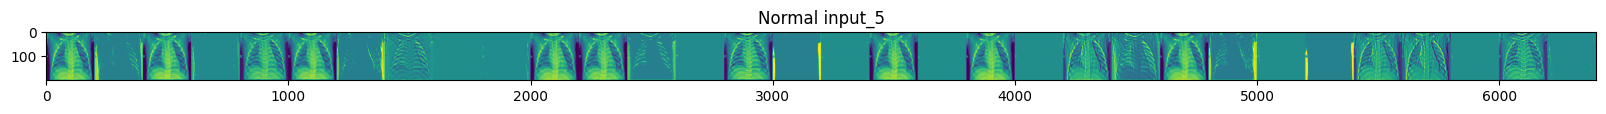

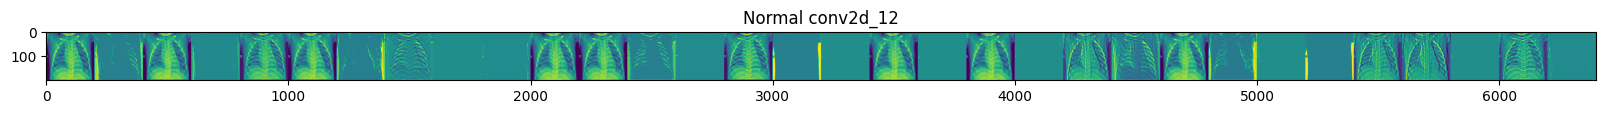

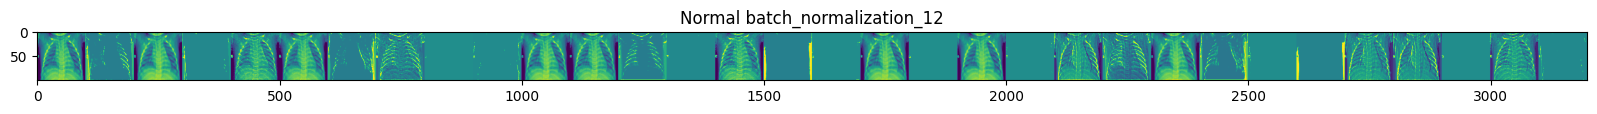

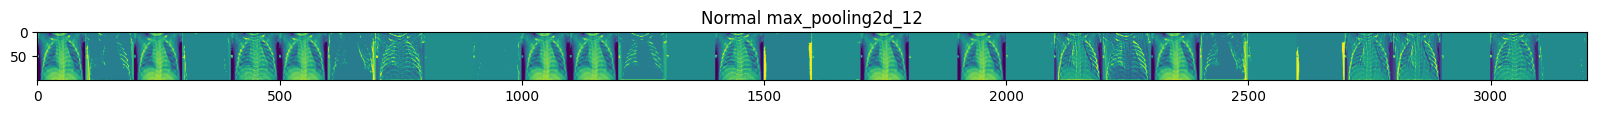

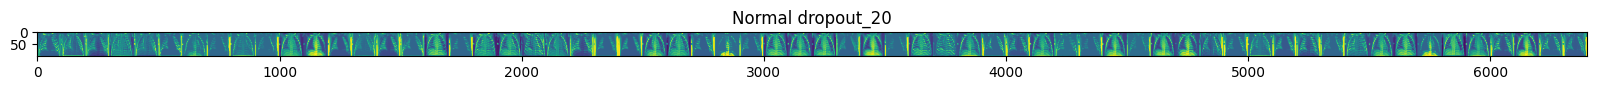

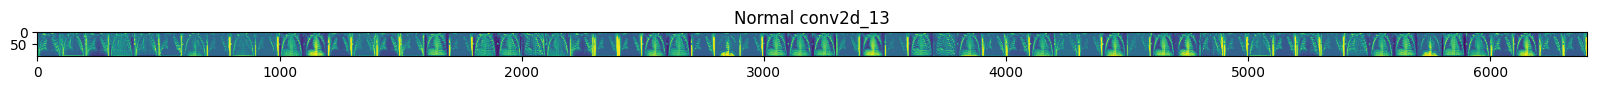

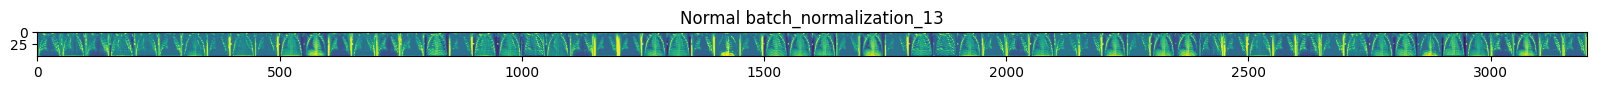

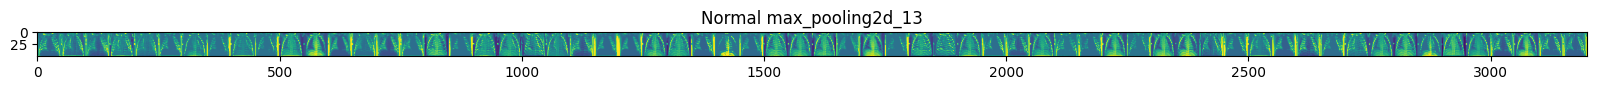

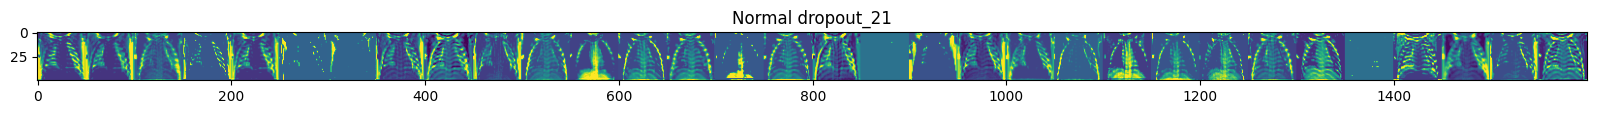

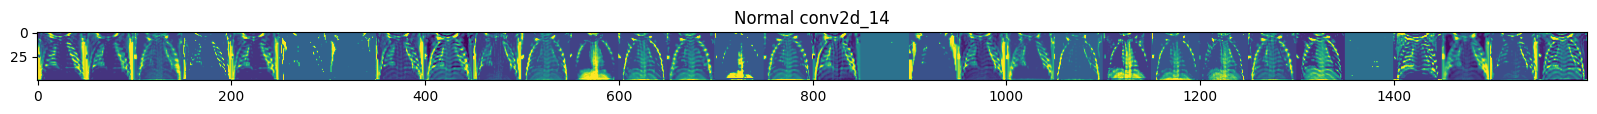

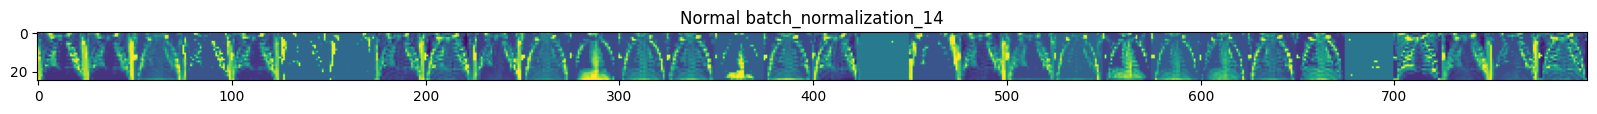

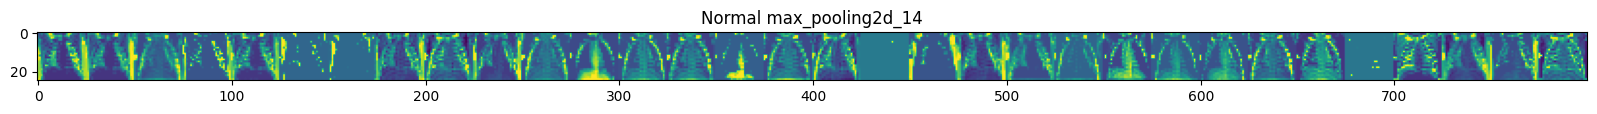

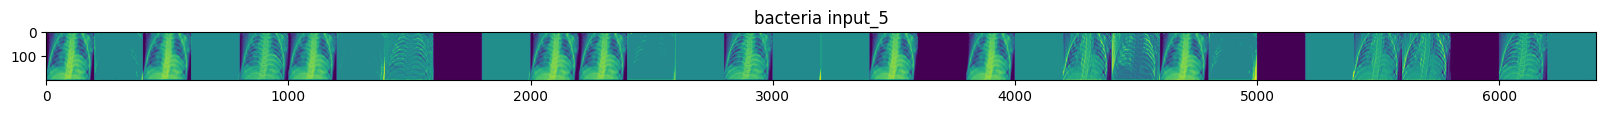

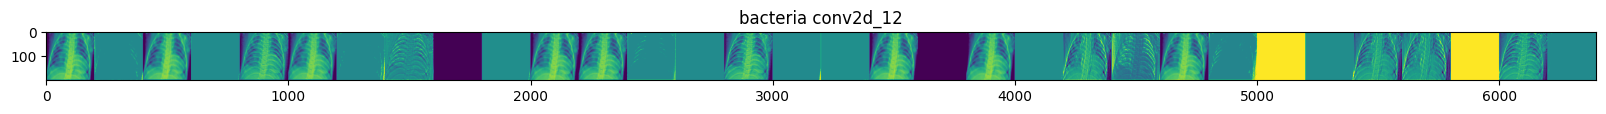

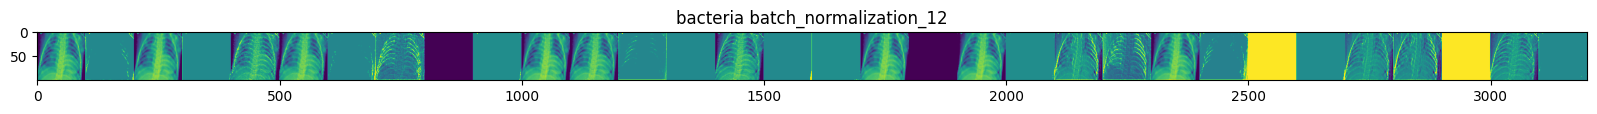

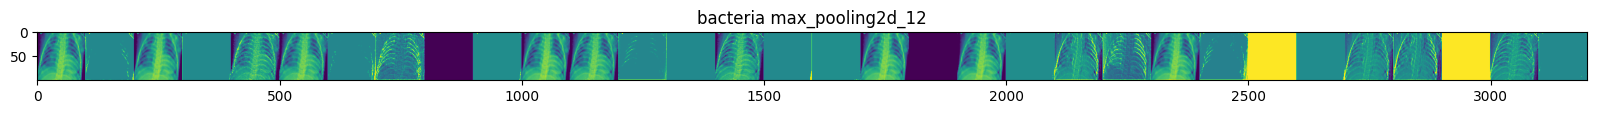

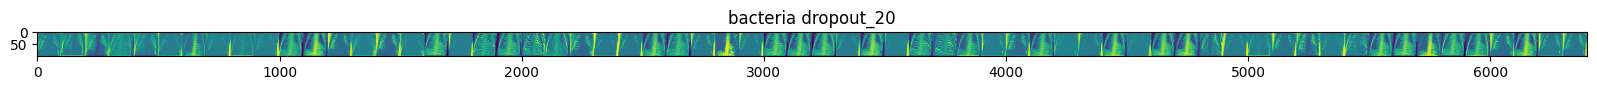

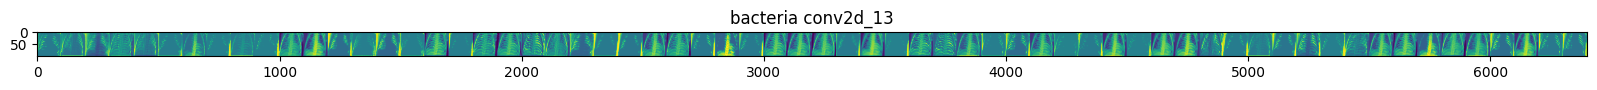

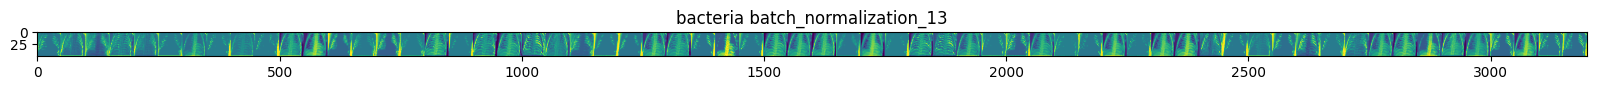

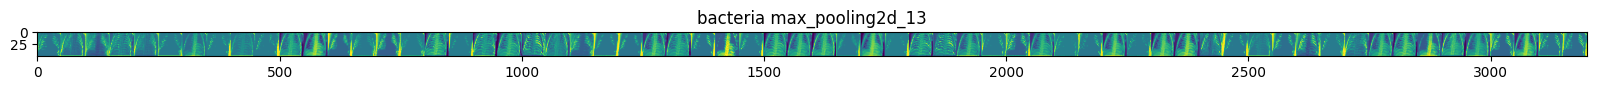

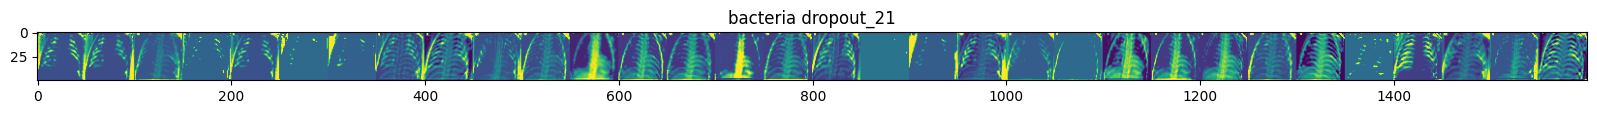

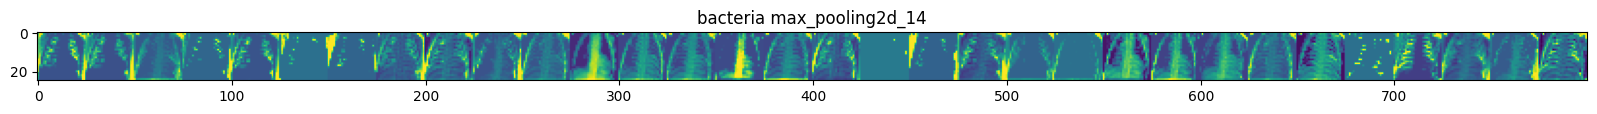

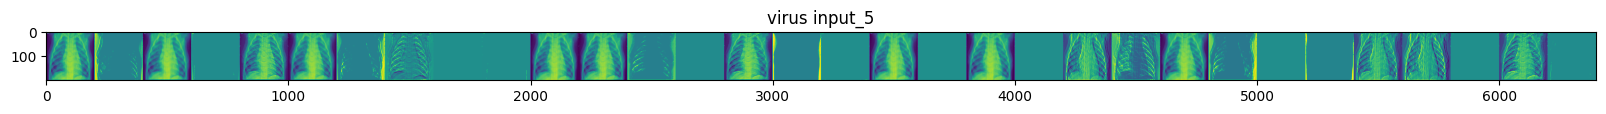

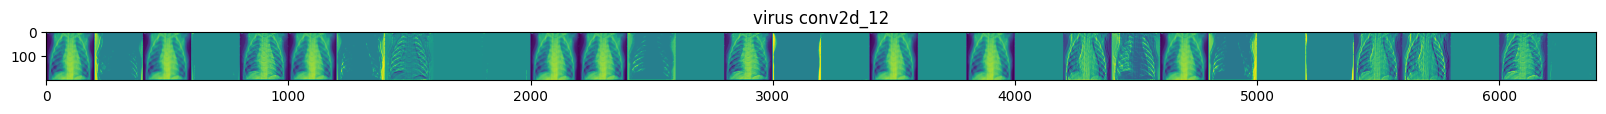

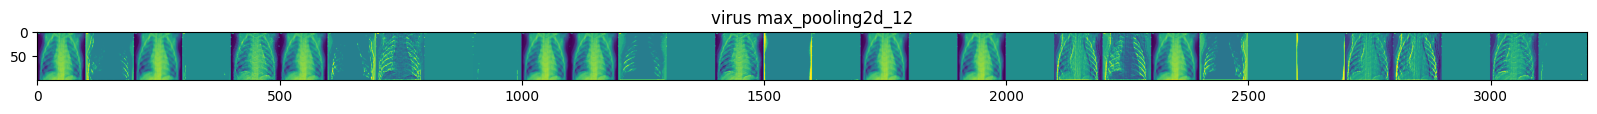

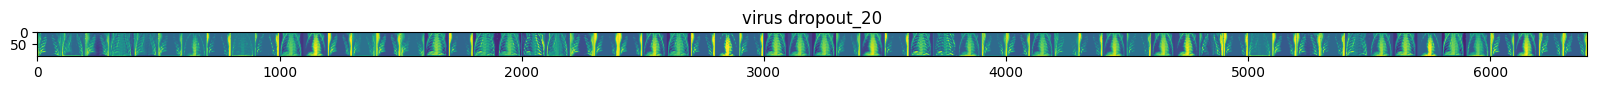

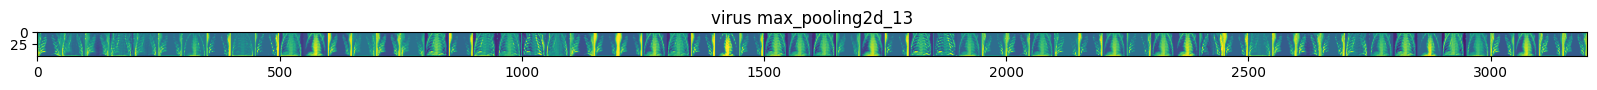

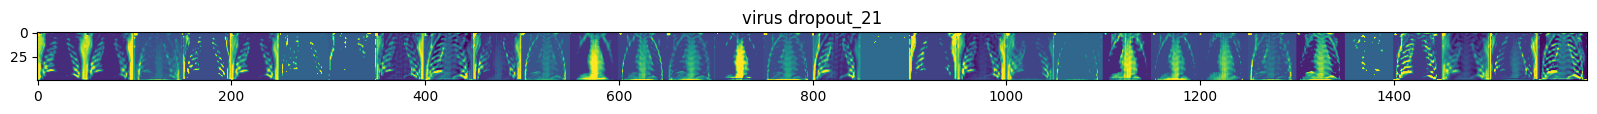

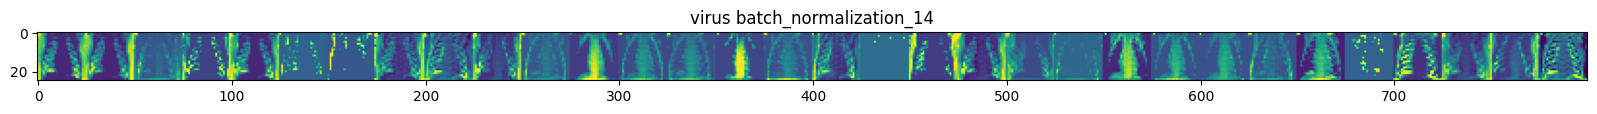

In [24]:
for key, (image, _) in image_prediction_acc.items():
  successive_outputs = [layer.output for layer in model.layers[1:]]
  visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

  successive_feature_maps = visualization_model.predict(np.expand_dims(image, axis=0))

  layer_names = [layer.name for layer in model.layers]
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
    
      n_features = feature_map.shape[-1] 
      size = feature_map.shape[ 1]  
      
      display_grid = np.zeros((size, size * n_features))
      
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size : (i + 1) * size] = x

      scale = 20. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title( class_names[int(key)] + " " +layer_name )
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap='viridis')